In [1]:
import utils
import cv2
import imutils
import glob
import os
import numpy as np
import json
import matplotlib.pyplot as plt
%matplotlib inline
import skimage

In [2]:
class ImageMerger:
    """
    ImageMerger can merge images from a dataset including images collected by a drone with the purpose of detecting 
    moving people in the images.
    """
    def __init__(self, data_dir, mask_file):
        """
        :param data_dir: path to the directory where the data is located
        :param mask_file: path of a mask which removes unneccesary text from the images
        """
        
        # Get all directories inside the data_dir
        self.data_dir = data_dir
        self.dirs = os.listdir(data_dir)
        self.mask = np.array(cv2.imread(mask_file)) // 255
        
        # Store the merged images
        self.merged_images = {}
        
    def load_images(self):
        """
        Loads the images and homographies from one directory at a time and yields them
        """
        
        for a_dir in self.dirs:
            if a_dir == 'labels.json':
                continue
            input_images = {}
            
            # Load all images in the train directory
            image_dir_file_path = os.path.join(os.path.join(self.data_dir, a_dir), '*.png')
            images = glob.glob(image_dir_file_path)
            
            # Copy all the raw images to the input images dict
            for im in images:
                file = os.path.basename(im)
                img_name = os.path.splitext(file)[0]
                src = cv2.cvtColor(cv2.imread(im), cv2.COLOR_BGR2RGB)
                #src = cv2.imread(im, cv2.IMREAD_GRAYSCALE)
                src = self.apply_mask(src)
                input_images[img_name] = src
            
            # Load the homographies json file
            homographies_file_path = os.path.join(os.path.join(self.data_dir, a_dir), 'homographies.json')
            with open(homographies_file_path, 'rb') as f:
                homographies = json.load(f)
            
            yield a_dir, input_images, homographies
        
    def apply_mask(self, image):
        """
        Applys the provided mask on image
        :param image: image file which will be treated as np.array
        """

        return image * self.mask
    
    def merge_images(self, alpha=0.1, axis=0, method='cltr', debug=False):
        """
        Merges all the images given the homographies which are retrieved from load_data. 
        :param alpha: Weighting for merging the images. The image to be merged on will be considered with a weight a alpha,
        the second image with a weight of 1-alpha.
        :param axis: defines the axis along which the images shall be merged. 0: camera axis, 1: time axis
        :param method: defines in which order the images shall be merged:
            - cltr: -B01 (along camera axis)/index 3 (along time axis) is the base image, the other images are merged on it
                    from left to right along the camera axis or from the first in time (index 0) to the last in time (index
                    6)
            - crtl: -B01 (along camera axis)/index 3 (along time axis) is the base image, the other images are merged on it
                    from right to left along the camera axis or from the last in time (index 6) to the first in time (index
                    0)
            - coutl: -B01 (along camera axis)/index 3 (along time axis) is the base image, the other images are merged on 
                    it from the center out switching between the left and right side of the center (along camera axis)/
                    previous and next in time (along time axis) starting with the left side/previous in time. 
            - coutr: -B01 (along camera axis)/index 3 (along time axis) is the base image, the other images are merged on 
                    it from the center out switching between the left and right side of the center (along camera axis)/
                    previous and next in time (along time axis) starting with the right side/next in time.
            - cinl: -B01 (along camera axis)/index 3 (along time axis) is the base image, the other images are merged on 
                    it from the outside inward switching between the left and right side of the center (along camera axis)/
                    previous and next in time (along time axis) starting with the left side/previous in time. 
            - cinr: -B01 (along camera axis)/index 3 (along time axis) is the base image, the other images are merged on 
                    it from the outside inward switching between the left and right side of the center (along camera axis)/
                    previous and next in time (along time axis) starting with the right side/next in time.
        :param debug: if True, results are printed to be able to debug 
        """
        
        # Define the keys and indices depending on axis and method
        keys = []
        indices = []
        base = None
        if axis == 0:
            indices = range(0, 7)
            if method == 'cltr':
                base = '-B01'
                keys = ['-B05', '-B04', '-B03', '-B02', '-G01', '-G02', '-G03', '-G04', '-G05']
            elif method == 'crtl': 
                base = '-B01'
                keys = ['-G05', '-G04', '-G03', '-G02', '-G01', '-B02', '-B03', '-B04', '-B05']
            elif method == 'coutl':
                base = '-B01'
                keys = ['-B02', '-G01', '-B03', '-G02', '-B04', '-G03', '-B05', '-G04', '-G05']
            elif method == 'coutr':
                base = '-B01'
                keys = ['-G01', '-B02', '-G02', '-B03', '-G03', '-B04', '-G04', '-B05', '-G05']
            elif method == 'cinl':
                base = '-B01'
                keys = ['-B05', '-G05', '-B04', '-G04', '-B03', '-G03', '-B02', '-G02', '-G01']
            elif method == 'cinr':
                base = '-B01'
                keys = ['-G05', '-B05', '-G04', '-B04', '-G03', '-B03', '-G02', '-B02', '-G01']
        elif axis == 1:
            indices = ['-B05', '-B04', '-B03', '-B02', '-B01', '-G01', '-G02', '-G03', '-G04', '-G05']
            if method == 'cltr':
                base = 3
                keys = [0, 1, 2, 4, 5, 6]
            elif method == 'crtl': 
                base = 3
                keys = [6, 5, 4, 2, 1, 0]
            elif method == 'coutl':
                base = 3
                keys = [2, 4, 1, 5, 0, 6]
            elif method == 'coutr':
                base = 3
                keys = [4, 2, 5, 1, 6, 0]
            elif method == 'cinl':
                base = 3
                keys = [0, 6, 1, 5, 2, 4]
            elif method == 'cinr':
                base = 3
                keys = [6, 0, 5, 1, 4, 2]
                
        # Do the merging by looping through all indices and keys
        for a_dir, images, homographies in self.load_images():
            # Loop through the indices
            for i in indices: 
                # Load the base image depending on the method
                base_image_key = ''
                if axis == 0:
                    base_image_key = str(i) + base
                elif axis == 1:
                    base_image_key = str(base) + i
                    
                # Define the merged image and set it to the base image as the start
                merged_image = images[base_image_key]
                
                if debug:
                    print('directory: ', a_dir)
                    print('base key: ', base_image_key)

                for k in keys:
                    # Get the key given the index and k
                    key = ''
                    if axis == 0:
                        key = str(i) + k
                    elif axis == 1:
                         key = str(k) + i
                        
                    # Load the image and the corresponding homography matrix
                    im = images[key]
                    homography = np.array(homographies[key])
                    
                    # Warp the perspective (i.e. transform the current image into the perspective of the base image (-B01))
                    im_warped = cv2.warpPerspective(im, homography, im.shape[:2])
                    # Merge the images
                    merged_image = cv2.addWeighted(merged_image, alpha, im_warped, 1 - alpha, 0.0)

                self.merged_images[a_dir+str(i)] = merged_image
                if debug:
                    plt.imshow(merged_image)
                    plt.show()
            #break
        return self.merged_images

In [3]:
image_merger = ImageMerger('data_WiSAR/data/validation/', 'data_WiSAR/data/mask.png')
valid_images = image_merger.merge_images(axis=0, method='coutl', debug=False)

All validation images with ground truth bounding boxes:

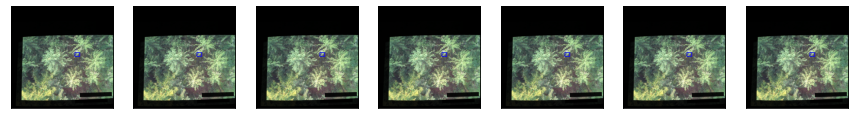

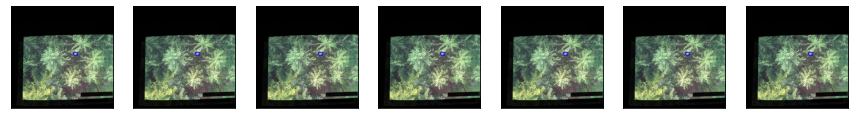

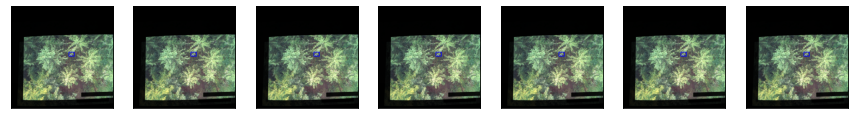

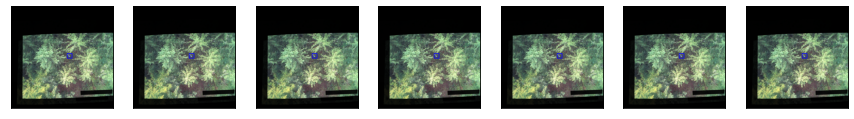

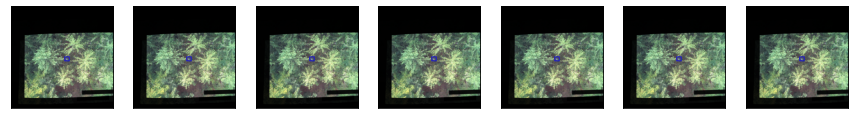

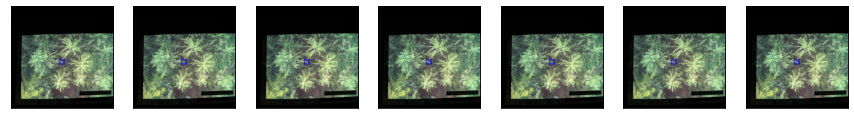

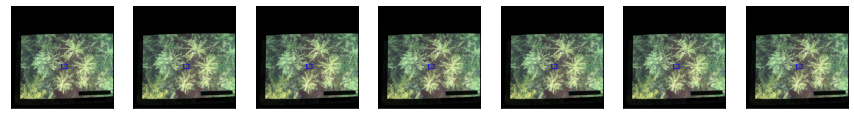

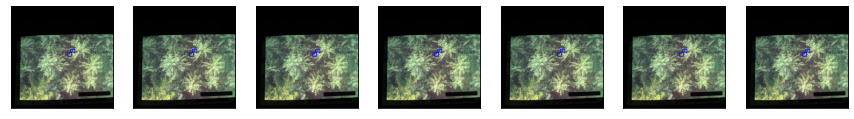

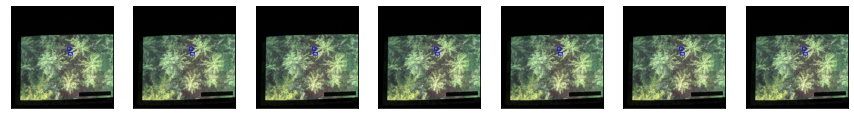

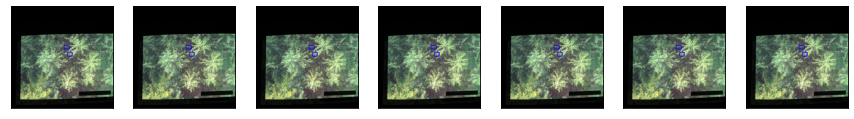

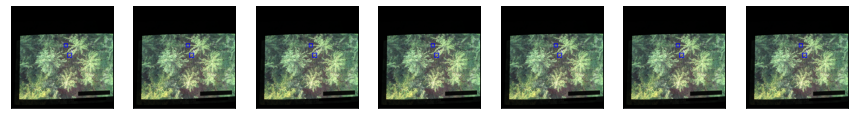

In [4]:
with open('data_WiSAR/data/validation/labels.json', "r") as read_file:
    gtlabels = json.load(read_file)

for i in range(7):
    for bb in gtlabels['valid-1-0']:
        x,y,w,h = bb
        bb = cv2.rectangle(valid_images['valid-1-0'+str(i)],(x, y),(x+w, y+h),(0,0,255),5)
    for bb in gtlabels['valid-1-1']:
        x,y,w,h = bb
        bb = cv2.rectangle(valid_images['valid-1-1'+str(i)],(x, y),(x+w, y+h),(0,0,255),5)
    for bb in gtlabels['valid-1-2']:
        x,y,w,h = bb
        bb = cv2.rectangle(valid_images['valid-1-2'+str(i)],(x, y),(x+w, y+h),(0,0,255),5)
    for bb in gtlabels['valid-1-3']:
        x,y,w,h = bb
        bb = cv2.rectangle(valid_images['valid-1-3'+str(i)],(x, y),(x+w, y+h),(0,0,255),5)
    for bb in gtlabels['valid-1-4']:
        x,y,w,h = bb
        bb = cv2.rectangle(valid_images['valid-1-4'+str(i)],(x, y),(x+w, y+h),(0,0,255),5)
    for bb in gtlabels['valid-1-5']:
        x,y,w,h = bb
        bb = cv2.rectangle(valid_images['valid-1-5'+str(i)],(x, y),(x+w, y+h),(0,0,255),5)
    for bb in gtlabels['valid-1-6']:
        x,y,w,h = bb
        bb = cv2.rectangle(valid_images['valid-1-6'+str(i)],(x, y),(x+w, y+h),(0,0,255),5)
    for bb in gtlabels['valid-2-0']:
        x,y,w,h = bb
        bb = cv2.rectangle(valid_images['valid-2-0'+str(i)],(x, y),(x+w, y+h),(0,0,255),5)
    for bb in gtlabels['valid-2-1']:
        x,y,w,h = bb
        bb = cv2.rectangle(valid_images['valid-2-1'+str(i)],(x, y),(x+w, y+h),(0,0,255),5)
    for bb in gtlabels['valid-2-2']:
        x,y,w,h = bb
        bb = cv2.rectangle(valid_images['valid-2-2'+str(i)],(x, y),(x+w, y+h),(0,0,255),5)
    for bb in gtlabels['valid-2-3']:
        x,y,w,h = bb
        bb = cv2.rectangle(valid_images['valid-2-3'+str(i)],(x, y),(x+w, y+h),(0,0,255),5)

#fig=plt.figure(figsize=(15,3))
#for image in range(77):
#    fig.add_subplot(7,11,image+1)
fig=plt.figure(figsize=(15,3))
for image in range(7):
    fig.add_subplot(1,7,image+1)
    plt.xticks([]),plt.yticks([])
    plt.imshow(valid_images['valid-1-0'+str(i)])

fig=plt.figure(figsize=(15,3))
for image in range(7):
    fig.add_subplot(1,7,image+1)
    plt.xticks([]),plt.yticks([])
    plt.imshow(valid_images['valid-1-1'+str(i)])

fig=plt.figure(figsize=(15,3))
for image in range(7):
    fig.add_subplot(1,7,image+1)
    plt.xticks([]),plt.yticks([])
    plt.imshow(valid_images['valid-1-2'+str(i)])
    
fig=plt.figure(figsize=(15,3))
for image in range(7):
    fig.add_subplot(1,7,image+1)
    plt.xticks([]),plt.yticks([])
    plt.imshow(valid_images['valid-1-3'+str(i)])
    
fig=plt.figure(figsize=(15,3))
for image in range(7):
    fig.add_subplot(1,7,image+1)
    plt.xticks([]),plt.yticks([])
    plt.imshow(valid_images['valid-1-4'+str(i)])
    
fig=plt.figure(figsize=(15,3))
for image in range(7):
    fig.add_subplot(1,7,image+1)
    plt.xticks([]),plt.yticks([])
    plt.imshow(valid_images['valid-1-5'+str(i)])

fig=plt.figure(figsize=(15,3))
for image in range(7):
    fig.add_subplot(1,7,image+1)
    plt.xticks([]),plt.yticks([])
    plt.imshow(valid_images['valid-1-6'+str(i)])
    
fig=plt.figure(figsize=(15,3))
for image in range(7):
    fig.add_subplot(1,7,image+1)
    plt.xticks([]),plt.yticks([])
    plt.imshow(valid_images['valid-2-0'+str(i)])
fig=plt.figure(figsize=(15,3))
for image in range(7):
    fig.add_subplot(1,7,image+1)
    plt.xticks([]),plt.yticks([])
    plt.imshow(valid_images['valid-2-1'+str(i)])

fig=plt.figure(figsize=(15,3))
for image in range(7):
    fig.add_subplot(1,7,image+1)
    plt.xticks([]),plt.yticks([])
    plt.imshow(valid_images['valid-2-2'+str(i)])

fig=plt.figure(figsize=(15,3))
for image in range(7):
    fig.add_subplot(1,7,image+1)
    plt.xticks([]),plt.yticks([])
    plt.imshow(valid_images['valid-2-3'+str(i)])

plt.show()

In [5]:
image_merger = ImageMerger('data_WiSAR/data/train/', 'data_WiSAR/data/mask.png')
train_images = image_merger.merge_images(axis=0, method='coutl', debug=False)

In [6]:
train_images['train-2-06'].shape # train-1-00 - train-1-06

(1024, 1024, 3)

Modified Mahalanobis:

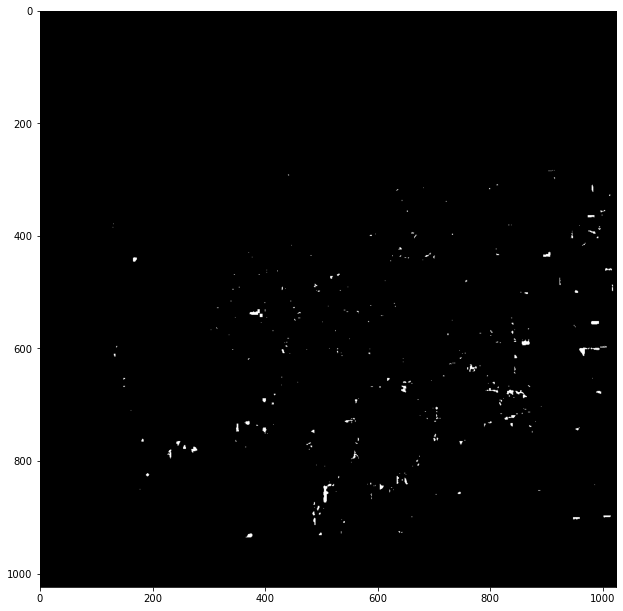

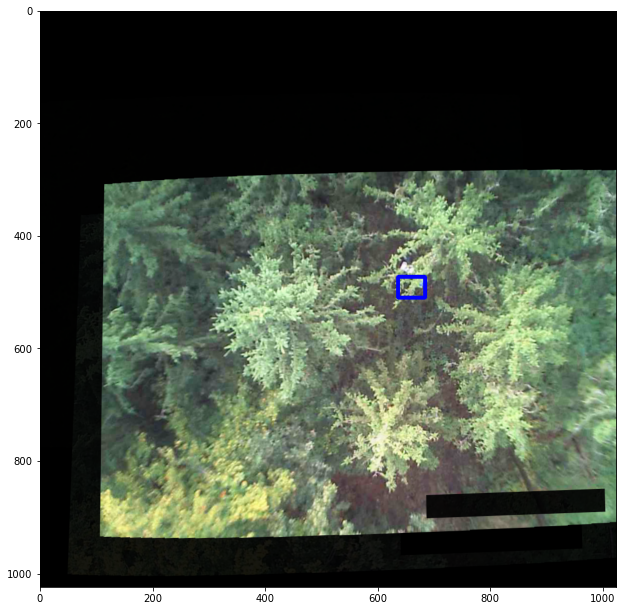

In [14]:
class dM(object):
    def __init__(self, array):
        self.array = array
        self.Xpix = array.shape[0]
        self.Ypix = array.shape[1]
 
    def Mahalanobis(self, threshold=4):
        mean_vector = np.mean(self.array, axis=(0, 1))
        variance_covariance = self.__variance_covariance_()
 
        # iterate over the original image and store dM in this new array
        distances = np.zeros([self.Xpix, self.Ypix])
        for i in range(self.Xpix):
            for j in range(self.Ypix):
                distances[i][j] = np.sqrt(np.dot(np.dot(np.transpose(\
                self.array[i][j] - mean_vector), variance_covariance), \
                self.array[i][j] - mean_vector))
        
        anomaly = np.zeros_like(distances)
        purified = self.array.copy()
        for i in range(distances.shape[0]):
            for j in range(distances.shape[1]):
                if distances[i,j] > threshold:
                    window = distances[i-30:i+30,j-30:j+30]
                    #print(window.size)
                    #print(len(np.where( window < threshold )[0]))
                    #ads
                    if len(np.where( window < threshold )[0]) > window.size-(window.size*0.1):
                        window_array = self.array[i-30:i+30,j-30:j+30]
                        window_mean = np.mean(window_array)
                        anomaly[i,j] = 1
                        purified[i,j] = window_mean
                    else:
                        anomaly[i,j] = 0
                else:
                    anomaly[i,j] = 0
        return distances, anomaly, purified
 
    def __variance_covariance_(self, number=10000): 
    
        reshaped_array = self.array.reshape((self.Xpix * self.Ypix, 3))
        
        # sample the above array to reduce computing time
        choices = np.random.randint(0, len(reshaped_array), number)
        reshaped_array = np.array([reshaped_array[i] for i in choices])
        average = np.mean(reshaped_array)
        # compute the variance-covariance matrix for these RGB data
        matrix = np.array(sum([np.outer(np.array([reshaped_array[i] - \
           average]), np.array(reshaped_array[i] - average)) for i in \
            range(len(reshaped_array))]) / len(reshaped_array))
 
        return np.linalg.inv(matrix)

image = valid_images['valid-1-00']

metric = dM(image)
distances, anomaly, purified = metric.Mahalanobis(threshold=3)
plt.figure(figsize=(10.6, 10.6))
plt.imshow(anomaly, cmap='gray')
plt.figure(figsize=(10.6, 10.6))
plt.imshow(image)
#plt.figure(figsize=(10.6, 10.6))
#plt.imshow(purified)

In [20]:
def getBoundingBoxValues(orig, anomaly, area=150):
    final = orig.copy()

    # Read image
    im = anomaly.copy().astype(np.uint8)

    # Detecting contours in image.
    contours, _= cv2.findContours(im, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    bb_vals = []
    for i in range(len(contours)):
        x_min = np.max(np.min(contours[i], axis=0))
        x_max = np.max(np.min(contours[i], axis=1))
        y_min = np.min(np.min(contours[i], axis=2))
        y_max = np.max(np.min(contours[i], axis=2))
        width = x_max-x_min
        height = y_max-y_min
        cur_area = width*height
        if cur_area > area and x_min > 110 and y_min > 300 and y_max < 950: # restrict to the borders of the black area
            bb_vals.append([x_min, y_min, width, height])
            bb = cv2.rectangle(final,(x_min, y_min),(x_max, y_max),(0,150,50),2)
    return bb_vals

In [21]:
def AnomalyDetection(text, image, labels):
    metric = dM(image)
    distances, anomaly, purified = metric.Mahalanobis(threshold=4.3)
    bb_pred = getBoundingBoxValues(image, anomaly, area=175)
    return bb_pred

bb_pred_dict = dict()
for i in range(1):
    bb_pred_dict['valid-1-0'] = AnomalyDetection('valid-1-0'+str(i), valid_images['valid-1-0'+str(i)], gtlabels['valid-1-0'])
    bb_pred_dict['valid-1-1'] = AnomalyDetection('valid-1-1'+str(i), valid_images['valid-1-1'+str(i)], gtlabels['valid-1-1'])
    bb_pred_dict['valid-1-2'] = AnomalyDetection('valid-1-2'+str(i), valid_images['valid-1-2'+str(i)], gtlabels['valid-1-2'])
    bb_pred_dict['valid-1-3'] = AnomalyDetection('valid-1-3'+str(i), valid_images['valid-1-3'+str(i)], gtlabels['valid-1-3'])
    bb_pred_dict['valid-1-4'] = AnomalyDetection('valid-1-4'+str(i), valid_images['valid-1-4'+str(i)], gtlabels['valid-1-4'])
    bb_pred_dict['valid-1-5'] = AnomalyDetection('valid-1-5'+str(i), valid_images['valid-1-5'+str(i)], gtlabels['valid-1-5'])
    bb_pred_dict['valid-1-6'] = AnomalyDetection('valid-1-6'+str(i), valid_images['valid-1-6'+str(i)], gtlabels['valid-1-6'])
    bb_pred_dict['valid-2-0'] = AnomalyDetection('valid-2-0'+str(i), valid_images['valid-2-0'+str(i)], gtlabels['valid-2-0'])
    bb_pred_dict['valid-2-1'] = AnomalyDetection('valid-2-1'+str(i), valid_images['valid-2-1'+str(i)], gtlabels['valid-2-1'])
    bb_pred_dict['valid-2-2'] = AnomalyDetection('valid-2-2'+str(i), valid_images['valid-2-2'+str(i)], gtlabels['valid-2-2'])
    bb_pred_dict['valid-2-3'] = AnomalyDetection('valid-2-3'+str(i), valid_images['valid-2-3'+str(i)], gtlabels['valid-2-3'])

In [22]:
bb_pred_dict

{'valid-1-0': [],
 'valid-1-1': [[927, 343, 15, 14], [817, 418, 18, 11]],
 'valid-1-2': [[802, 384, 24, 13]],
 'valid-1-3': [],
 'valid-1-4': [],
 'valid-1-5': [],
 'valid-1-6': [],
 'valid-2-0': [[876, 395, 24, 9]],
 'valid-2-1': [],
 'valid-2-2': [],
 'valid-2-3': []}